# 0 Configuration

In [1]:
config = {
    "modeling": {
        "dummy": False,
        "linear_reg": False,
        "svr": False,
        "tree": False,
        "forest": False,
        "xgboost": True
    },
    "explain": {
        "setup": False,
        "bar": False,
        "force": False,
        "waterfall": False,
        "summary": False,
        "dependence": False
    },
}

***
# 1 Dependency import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, minmax_scale
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import set_config

import xgboost
from xgboost import XGBRegressor

import shap
shap.initjs()

plt.style.use(["default"])
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

In [3]:
def get_categorical_features_name(dataset, split_by_unique_count=True, split_count=10):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values

In [4]:
def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(["int64", "float64"]).columns.values.tolist()
    return features_name

In [63]:
class EvaluationResult():
    def __init__(self, gridsearch, target, X_train, y_train, X_test, y_test, num_cols, cat_less_unique_cols, cat_lot_unique_cols):
        self.__gs = gridsearch
        self.__X_train = X_train
        self.y_train = y_train
        self.__X_test = X_test
        self.y_test = y_test
        self.__target = target
        self.__score = self.__gs.score(self.__X_test, self.y_test)
        self.__ratio = np.abs((self.__score * 100) / self.y_test.mean())
        self.__num_cols = num_cols
        self.__cat_less_unique_cols = cat_less_unique_cols
        self.__cat_lot_unique_cols = cat_lot_unique_cols
        self.__cat_less_unique_cols_preproc = self.__gs.best_estimator_["transforms"].transformers_[1][1]["one_hot_encoder"].get_feature_names_out(self.__cat_less_unique_cols).tolist()

        self.best_model = self.__gs.best_estimator_.named_steps["model"]
        self.feature_names = self.__num_cols + self.__cat_less_unique_cols_preproc + self.__cat_lot_unique_cols

        self.X_train_transform = pd.DataFrame(data=self.__gs.best_estimator_.named_steps["transforms"].transform(self.__X_train), columns=self.feature_names)
        self.X_test_transform = pd.DataFrame(data=self.__gs.best_estimator_.named_steps["transforms"].transform(self.__X_test), columns=self.feature_names)

    def print_metrics(self):
        print(f"RMSE: {-self.__score:.4}")
        print(f"Target mean value: {self.__target.mean():.4} +/- {self.__target.std():.4}")
        print(f"Ratio: {self.__ratio:.4}%")
        print(f"best_params: {self.__gs.best_params_}")

    def print_feature_importance(self, show_raw=True):
        fi = pd.Series(self.best_model.feature_importances_, index=self.feature_names).sort_values(ascending=False)

        fi.plot.bar(figsize=(20, 3))

        plt.title("Feature importances using MDI", size=20)
        plt.ylabel("Mean decrease in impurity", size=16)
        plt.xticks(rotation=45, size=16, ha="right")
        plt.yticks(size=16)
        plt.show()

        if show_raw:
            print(fi)

In [6]:
def evaluate(model, grid_params, dataset, target, scoring="neg_root_mean_squared_error"):
    set_config(display="diagram") # display="text" -> for textual output

    ### DATASET PREPARATION ###

    y = dataset[target].copy()
    X = dataset.drop(columns=[target]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

    categorical_cols_less_unique, categorical_cols_lot_unique = get_categorical_features_name(X_train)
    numerical_cols = get_numerical_features_name(X_train)

    ### PIPELINE CONSTRUCTION ###

    num_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="mean")),
    ])

    cat_less_unique_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    cat_lot_unique_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ("simple_imputer_bis", SimpleImputer(strategy="mean")),
    ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, numerical_cols),
        ("cat_less_unique_pipe", cat_less_unique_pipe, categorical_cols_less_unique),
        ("cat_lot_unique_pipe", cat_lot_unique_pipe, categorical_cols_lot_unique)
    ])

    pipeline = Pipeline([
        ("transforms", preprocessor),
        ("model", model)
    ])

    ### GRIDSEARCH DECLARATION AND FITTING ###

    gs = GridSearchCV(pipeline, grid_params, scoring=scoring, refit=True)
    gs.fit(X_train, y_train)

    return EvaluationResult(gs, y, X_train, y_train, X_test, y_test, numerical_cols, categorical_cols_less_unique, categorical_cols_lot_unique)

In [7]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

***
# 2 Loading data

In [9]:
data = pd.read_csv("data/data-cleaned.csv", delimiter=",")

In [10]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [11]:
target_1 = "SiteEnergyUse(kBtu)"
target_2 = "GHGEmissionsIntensity"

In [12]:
data.drop(columns=[target_2], inplace=True)

In [13]:
data.describe()

,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu)
count,3289.000000,3301.000000,3304.000000,3304.000000,3304.000000,3304.000000,3296.000000,3304.000000,3304.000000,2474.000000,3.335000e+03
mean,42.292227,8.619726,57.856084,53.778375,41.735278,60.170973,1.988225,5.711259,2.554309,67.791027,5.420357e+06
std,6.941364,5.265092,34.946169,20.199073,13.953138,28.446297,1.899759,5.509427,6.278271,26.719378,2.170926e+07
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
25%,37.845865,4.508709,34.000000,43.626523,33.569479,42.967391,1.891892,3.000000,1.000000,53.000000,9.360823e+05
50%,41.567669,7.115132,50.500000,51.503920,42.882545,65.565217,1.891892,5.000000,1.000000,75.000000,1.811506e+06
75%,44.172932,13.467744,100.000000,67.800746,49.669187,84.504348,1.891892,6.000000,1.000000,90.000000,4.222455e+06
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,8.739237e+08


In [14]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
data["DefaultData"] = data["DefaultData"].astype("object")

In [16]:
data.describe(include="object")

,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,DefaultData,ComplianceStatus
count,3335,3335,3335,3335,3335,3335,3324,1663,589,3335,3335
unique,8,24,3319,3312,14,463,56,50,44,2,4
top,nonresidential,low-rise multifamily,northgate plaza,309 south cloverdale street,downtown,multifamily housing,multifamily housing,parking,retail store,False,compliant
freq,1443,968,3,4,564,859,1651,968,109,3224,3207


In [17]:
# data.drop(columns=["ThirdLargestPropertyUseType"], inplace=True)

***
# 3 Feature engineering

## 3.1 Overview

In [18]:
data.head()

,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus
0,nonresidential,hotel,mayflower park hotel,405 olive way,36.357143,2.168207,100.0,downtown,48.677759,40.060326,24.243478,1.891892,13.0,1.000000,hotel,hotel,NaN,NaN,60.0,7226362.5,False,compliant
1,nonresidential,hotel,paramount hotel,724 pine street,36.357143,2.168207,100.0,downtown,49.086919,42.139856,83.643478,1.891892,12.0,3.909311,"hotel, parking, restaurant",hotel,parking,restaurant,61.0,8387933.0,False,compliant
2,nonresidential,hotel,5673-the westin seattle,1900 5th avenue,36.357143,2.168207,100.0,downtown,49.407499,40.003984,60.400000,1.891892,42.0,38.992154,hotel,hotel,NaN,NaN,43.0,72587024.0,False,compliant
3,nonresidential,hotel,hotel max,620 stewart st,36.357143,2.168208,100.0,downtown,49.487644,40.751795,23.382609,1.891892,11.0,1.000000,hotel,hotel,NaN,NaN,56.0,6794584.0,False,compliant
4,nonresidential,hotel,warwick seattle hotel (id8),401 lenora st,43.800752,2.168208,100.0,downtown,49.331572,38.790072,69.869565,1.891892,19.0,12.974062,"hotel, parking, swimming pool",hotel,parking,swimming pool,75.0,14172606.0,False,compliant


In [19]:
data.describe()

,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu)
count,3289.000000,3301.000000,3304.000000,3304.000000,3304.000000,3304.000000,3296.000000,3304.000000,3304.000000,2474.000000,3.335000e+03
mean,42.292227,8.619726,57.856084,53.778375,41.735278,60.170973,1.988225,5.711259,2.554309,67.791027,5.420357e+06
std,6.941364,5.265092,34.946169,20.199073,13.953138,28.446297,1.899759,5.509427,6.278271,26.719378,2.170926e+07
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
25%,37.845865,4.508709,34.000000,43.626523,33.569479,42.967391,1.891892,3.000000,1.000000,53.000000,9.360823e+05
50%,41.567669,7.115132,50.500000,51.503920,42.882545,65.565217,1.891892,5.000000,1.000000,75.000000,1.811506e+06
75%,44.172932,13.467744,100.000000,67.800746,49.669187,84.504348,1.891892,6.000000,1.000000,90.000000,4.222455e+06
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,8.739237e+08


In [20]:
data.describe(include="object")

,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,DefaultData,ComplianceStatus
count,3335,3335,3335,3335,3335,3335,3324,1663,589,3335,3335
unique,8,24,3319,3312,14,463,56,50,44,2,4
top,nonresidential,low-rise multifamily,northgate plaza,309 south cloverdale street,downtown,multifamily housing,multifamily housing,parking,retail store,False,compliant
freq,1443,968,3,4,564,859,1651,968,109,3224,3207


***
## 3.2 ListOfAllPropertyUseTypes

In [21]:
feature = "ListOfAllPropertyUseTypes"

In [22]:
def nb_elt_in_list(row):
    if type(row) == float:
        return 0
    else:
        return len(row.split(","))

new_feature = "Count_" + feature

data[new_feature] = data.apply(lambda row: nb_elt_in_list(row[feature]), axis=1)
data[[feature, new_feature]].head(10)

,ListOfAllPropertyUseTypes,Count_ListOfAllPropertyUseTypes
0,hotel,1
1,"hotel, parking, restaurant",3
2,hotel,1
3,hotel,1
4,"hotel, parking, swimming pool",3
5,police station,1
6,hotel,1
7,other - entertainment/public assembly,1
8,hotel,1
9,multifamily housing,1


In [23]:
data.drop(columns=[feature], inplace=True)

***
## 3.3 Address

Maybe the address incorporate informations that can be usefull for the model if it can be decomposed:
- number of building (405, 1619 ...)
- stress name (olive, 5th, fourth ...)
- kind of way (way, street, avenue, st ...)

In [24]:
feature = "Address"

In [25]:
data[feature].describe()

count                            3335
unique                           3312
top       309 south cloverdale street
freq                                4
Name: Address, dtype: object

In [26]:
data[feature].head(20)

0          405 olive way
1        724 pine street
2        1900 5th avenue
3         620 stewart st
4          401 lenora st
5        810 virginia st
6        1619 9th avenue
7            911 pine st
8            612 2nd ave
9         607 - 3rd ave.
10       1101 4th avenue
11    1112 fourth avenue
12     400 spring street
13          1113 6th ave
14       1100 5th avenue
15    1000 fourth avenue
16        909 4th avenue
17    515 madison street
18          820 4th ave.
19           700 3rd ave
Name: Address, dtype: object

In [27]:
data[feature].replace(to_replace="[-.&]|( s )|( e )|( n )|( ne )|( sw )|( st)|( nw )|( w )", value="", regex=True, inplace=True)
new_df = data[feature].str.split(expand=True).rename(columns={0: "BuildingNumber", 1: "WayName", 2: "WayKind"}).iloc[:, :3]
new_df.head(10)

,BuildingNumber,WayName,WayKind
0,405,olive,way
1,724,pinereet,None
2,1900,5th,avenue
3,620ewart,None,None
4,401,lenora,None
5,810,virginia,None
6,1619,9th,avenue
7,911,pine,None
8,612,2nd,ave
9,607,3rd,ave


In [28]:
new_df["BuildingNumber"] = pd.to_numeric(new_df["BuildingNumber"], errors="coerce", downcast="integer")
new_df["BuildingNumber"] = new_df["BuildingNumber"].replace(np.nan, new_df["BuildingNumber"].mean())
new_df.head(20)

,BuildingNumber,WayName,WayKind
0,405.00000,olive,way
1,724.00000,pinereet,None
2,1900.00000,5th,avenue
3,137070.37265,None,None
4,401.00000,lenora,None
5,810.00000,virginia,None
6,1619.00000,9th,avenue
7,911.00000,pine,None
8,612.00000,2nd,ave
9,607.00000,3rd,ave


In [29]:
new_df["BuildingNumber"] = minmax_scale(new_df["BuildingNumber"], feature_range=(1, 100))
new_df.head(20)

,BuildingNumber,WayName,WayKind
0,1.000595,olive,way
1,1.001067,pinereet,None
2,1.002804,5th,avenue
3,1.202483,None,None
4,1.000589,lenora,None
5,1.001194,virginia,None
6,1.002389,9th,avenue
7,1.001343,pine,None
8,1.000901,2nd,ave
9,1.000894,3rd,ave


In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3335 entries, 0 to 3334
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BuildingNumber  3335 non-null   float64
 1   WayName         2864 non-null   object 
 2   WayKind         2542 non-null   object 
dtypes: float64(1), object(2)
memory usage: 78.3+ KB


In [31]:
data = data.join([new_df])

In [32]:
data.drop(columns=[feature], inplace=True)

***
## 3.4 Target

In [33]:
data[target_1].describe()

count    3.335000e+03
mean     5.420357e+06
std      2.170926e+07
min      0.000000e+00
25%      9.360823e+05
50%      1.811506e+06
75%      4.222455e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

In [34]:
data[data[target_1] < 1e5][target_1].count

<bound method Series.count of 28          0.00000
31          0.00000
62          0.00000
81          0.00000
85          0.00000
95          0.00000
133         0.00000
139         0.00000
152         0.00000
303         0.00000
609         0.00000
625         0.00000
740         0.00000
753         0.00000
964     90558.70313
1347        0.00000
1535        0.00000
1562    97690.39844
1563    57133.19922
1875        0.00000
2974    79711.79688
3128        0.00000
Name: SiteEnergyUse(kBtu), dtype: float64>

In [35]:
data[target_1].replace(0, data[target_1].mean(), inplace=True)

Text(0, 0.5, 'Occurence')

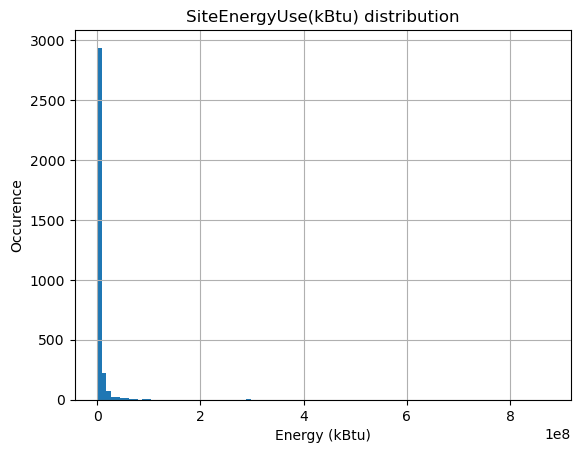

In [36]:
data[target_1].hist(bins=100)
plt.title(target_1 + " distribution")
plt.xlabel("Energy (kBtu)")
plt.ylabel("Occurence")

Text(0, 0.5, 'Occurence')

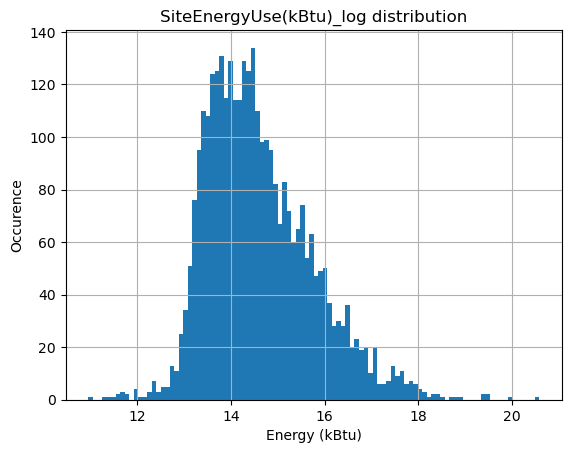

In [37]:
data[target_1] = np.log(data[target_1])
data[target_1].hist(bins=100)
plt.title(target_1 + "_log distribution")
plt.xlabel("Energy (kBtu)")
plt.ylabel("Occurence")

***
# 4 Modeling

## 4.1 DummyRegressor

In [38]:
%%time
if config["modeling"]["dummy"]:

    model = DummyRegressor()

    grid_params = [
        {
            "model__strategy": ["mean", "median"]
        },
        {
            "model__strategy": ["quantile"],
            "model__quantile": np.arange(0, 1.1, 0.1),
        }
    ]

    eval_result = evaluate(model, grid_params, data, target_1)

    eval_result.print_metrics()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


***
## 4.2 LinearRegression

In [39]:
%%time
if config["modeling"]["linear_reg"]:

    model = LinearRegression()

    grid_params = [
        {
            "model__fit_intercept": [True]
        }
    ]

    eval_result = evaluate(model, grid_params, data, target_1)

    eval_result.print_metrics()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


***
## 4.3 SupportVectorRegression

In [40]:
%%time
if config["modeling"]["svr"]:

    model = SVR()

    grid_params = [
        {
            "model__kernel": ["rbf"],
            "model__gamma": ["scale"]
        }
    ]

    eval_result = evaluate(model, grid_params, data, target_1)

    eval_result.print_metrics()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.78 µs


***
## 4.4 DecisionTreeRegressor

In [41]:
%%time
if config["modeling"]["tree"]:

    model = DecisionTreeRegressor()

    grid_params = [
        {
            "model__random_state": [1],
            "model__max_depth": [2, 3, 4],
            "model__min_samples_leaf": range(1, 11, 1),
            "model__criterion": ["squared_error"]
        }
    ]

    eval_result = evaluate(model, grid_params, data, target_1)

    eval_result.print_metrics()
    eval_result.print_feature_importance(show_raw=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


***
## 4.5 RandomForestRegressor

In [42]:
%%time
if config["modeling"]["forest"]:

    model = RandomForestRegressor()

    grid_params = [
        {
            "model__random_state": [1],
            "model__n_estimators": [25],
            "model__min_samples_leaf": [1],
            "model__criterion": ["squared_error"]
        }
    ]

    eval_result = evaluate(model, grid_params, data, target_1)

    eval_result.print_metrics()
    eval_result.print_feature_importance(show_raw=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


***
## 4.6 XGBRegressor

RMSE: 0.8098
Target mean value: 14.6 +/- 1.136
Ratio: 5.523%
best_params: {'model__booster': 'gbtree', 'model__eta': 0.07, 'model__eval_metric': 'rmse', 'model__gamma': 1.2, 'model__max_depth': 7, 'model__n_estimators': 100, 'model__random_state': 1}


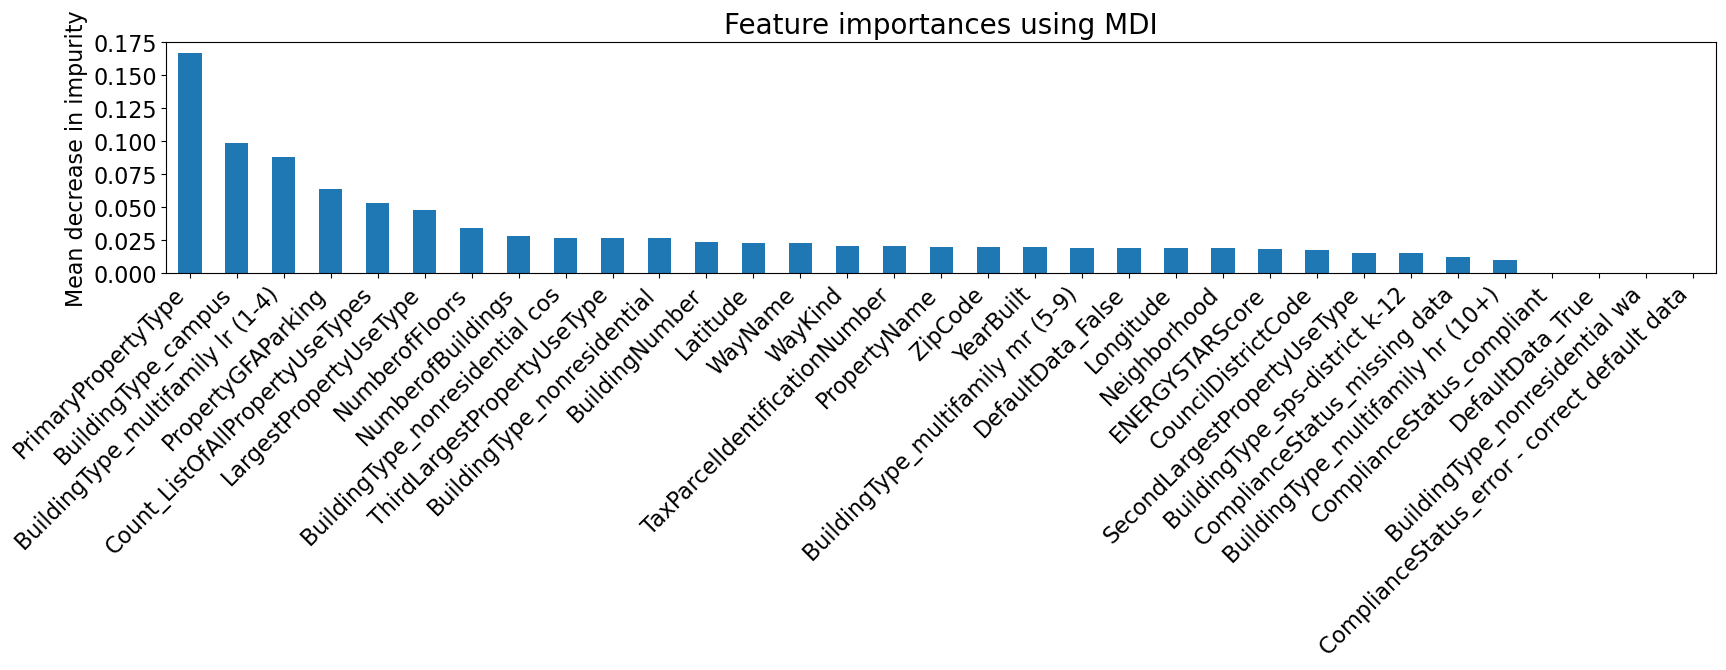

CPU times: user 47.6 s, sys: 1.11 s, total: 48.7 s
Wall time: 5.14 s


In [64]:
%%time
if config["modeling"]["xgboost"]:

    model = XGBRegressor()

    grid_params = [
        {
            "model__random_state": [1],
            "model__booster": ["gbtree"],
            "model__eta": [0.07], # np.arange(0, 0.1, 0.01),
            "model__gamma": [1.2], # np.arange(0, 3, 0.2),
            "model__max_depth": [7], #range(3, 9, 1),
            "model__eval_metric": ["rmse"],
            "model__n_estimators": [100], # range(0, 110, 10),
        }
    ]

    eval_result = evaluate(model, grid_params, data, target_1)

    eval_result.print_metrics()
    eval_result.print_feature_importance(show_raw=False)

***
# 5 Feature explainability

## 5.1 Explainer setup

In [44]:
%%time
if config["explain"]["setup"]:
    explainer = shap.TreeExplainer(eval_result.best_model, data=eval_result.X_train_transform)
    explainer_bis = explainer(eval_result.X_train_transform)
    shap_values = explainer.shap_values(eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


***
## 5.2 SHAP

In [45]:
%%time
if config["explain"]["bar"]:
    shap.plots.bar(explainer_bis)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [46]:
%%time
if config["explain"]["force"]:
    shap.force_plot(explainer.expected_value, shap_values[0,:], eval_result.X_train_transform.iloc[0,:], matplotlib=True)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


In [47]:
%%time
if config["explain"]["waterfall"]:
    shap.plots.waterfall(explainer_bis[0])

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 17.9 µs


***
## 5.3 Summary

In [48]:
%%time
if config["explain"]["summary"]:
    shap.summary_plot(shap_values, eval_result.X_train_transform)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


***
## 5.4 Dependence

In [49]:
%%time
if config["explain"]["dependence"]:
    shap.decision_plot(explainer.expected_value, shap_values, features=eval_result.X_train_transform, feature_names=eval_result.feature_names, ignore_warnings=True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [50]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("PrimaryPropertyType", shap_values, eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [51]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("BuildingType_multifamily lr (1-4)", shap_values, eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [52]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("LargestPropertyUseType", shap_values, eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [53]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("Count_ListOfAllPropertyUseTypes", shap_values, eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [54]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("BuildingNumber", shap_values, eval_result.X_train_transform)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


In [55]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("PropertyName", shap_values, eval_result.X_train_transform)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.78 µs


In [56]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("TaxParcelIdentificationNumber", shap_values, eval_result.X_train_transform)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [57]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("Latitude", shap_values, eval_result.X_train_transform)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [58]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("Longitude", shap_values, eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [59]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("WayName", shap_values, eval_result.X_train_transform)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [60]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("ENERGYSTARScore", shap_values, eval_result.X_train_transform)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [61]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("Neighborhood", shap_values, eval_result.X_train_transform)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [62]:
%%time
if config["explain"]["dependence"]:
    shap.dependence_plot("NumberofFloors", shap_values, eval_result.X_train_transform)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 17.6 µs
